In [1]:
import pickle
import copy

import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
class Model:
    def __init__(self, to_drop=None, target=None):
        """
        :param to_drop: python array with columns to drop
        :param target: python array with target columns
        """
        self.model = MultiOutputRegressor(xgb.XGBRegressor())

        if to_drop is None:
            to_drop = ["install_date", "target_full_ltv_day30"]
        if target is None:
            target=["target_ad_ltv_day30", "target_iap_ltv_day30", "target_sub_ltv_day30"]

        self.target = target
        self.to_drop = to_drop
        self.custom_one_hot_media = None
        self.custom_one_hot_country = None

    def split_data(self, data, train_size=0.99, no_duplicates=False, drop_na=True, below_zero=False, random_state=None):
        """
        :param data: df to split
        :param train_size: float, train size in range(0,1)
        :param no_duplicates: bool, to drop duplicates on train, default=False
        :param drop_na: bool, to drop na on train, default=True
        :param below_zero: bool, to leave values below zero on train, default=False
        :param random_state: int, random state of the split, default=None
        :return: python array of split data: [X_train, X_test, y_train, y_test]
        """
        data_copy = copy.deepcopy(data)

        X_train, X_test, y_train, y_test = train_test_split(data_copy.drop(self.target, axis=1), data_copy[self.target], random_state=random_state, train_size=train_size)

        X_train, y_train = self.preprocess_data(X_train, y_train, no_duplicates=no_duplicates, drop_na=drop_na, below_zero=below_zero)
        X_test, y_test = self.preprocess_data(X_test, y_test)

        return [X_train, X_test, y_train, y_test]

    def preprocess_data(self, X, y, no_duplicates=False, drop_na=False, below_zero=True):
        """
        :param X: df, features
        :param y: df, target
        :param no_duplicates: bool, to drop duplicates on train, default=False
        :param drop_na: bool, to drop na on train, default=True
        :param below_zero: bool, to leave values below zero on train, default=False
        :return: processed data
        """
        X.drop(labels=self.to_drop, axis=1, inplace=True)
        X = self.transform(X)

        if no_duplicates:
            indexes = ~X.duplicated()
            X, y = X[indexes], y[indexes]

        if drop_na:
            indexes = ~X.isna().any(axis=1)
            X, y = X[indexes], y[indexes]

        if not below_zero:
            indexes = ~(X<0).any(axis=1)
            X, y = X[indexes], y[indexes]

        return X,y

    def transform(self, data):
        """
        Custom one hot by most common categories.
        :param data: df
        :return: transformed df
        """
        data = copy.copy(data)
        if (self.custom_one_hot_media is None) or (self.custom_one_hot_country is None):
            self.one_hot_init(data)

        data['not_common_source'] = True
        data['not_common_country'] = True

        for source in self.custom_one_hot_media: ## Отбор популярных источников
            if source in data.columns:
                data[source] = (data['media_source'] == source).astype(int)
                data['not_common_source'] = np.logical_and((data['media_source'] != source), data['not_common_source'])

        for country in self.custom_one_hot_country:## Отбор популярных стран скачивания
            if country in data.columns:
                data[country] = (data['country_code'] == country).astype(int)
                data['not_common_country'] = np.logical_and((data['country_code'] != country), data['not_common_country'])

        data = pd.get_dummies(data, columns=['platform'], prefix = 'is_', drop_first = True)

        return data.drop(["media_source", "country_code"], axis=1)

    def one_hot_init(self, X):
        self.custom_one_hot_media = X['media_source'].value_counts()[:10].index.to_list()
        self.custom_one_hot_country = X['country_code'].value_counts()[:25].index.to_list()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, one_target=True):
        """
        :param X: df, features
        :param one_target: bool, if False 3 values would be predicted
        :return: df, predicted values
        """
        return (self.model.predict(X)).sum(axis=1) if one_target == True else self.model.predict(X)

    def get_metrics(self, X, y, one_target=True, model_name=None, RMSE=True, MAE=True, MAPE=True, R2=False, MSE=False):
        """
        :param model: ML model, which will predict on X
        :param X: data frame, features
        :param y: data frame, target values
        :param one_target: bool, print metrics for 1 target or for 3
        :param model_name: string, name of the model, if not None name will be printed
        :param RMSE: bool, Root mean square error
        :param MAE: bool, Mean absolute error
        :param MAPE: bool,Mean absolute percentage error
        :param R2: bool, Root 2 error
        :param MSE: bool, Mean square error
        :return: None, prints errors on specified metrics
        """
        metrics = (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error)
        metric_flags = {"RMSE": RMSE, "MAE": MAE, "MAPE": MAPE, "R2": R2, "MSE": MSE}

        print('-'*20)
        if model_name:
            print(f"Model = {model_name}")
        for metric, m_flag in zip(metrics, metric_flags):
            if metric_flags[m_flag]:
                if m_flag=='RMSE':
                    print(f"{m_flag} on 3 target = {metric(y, self.model.predict(X), squared=False)}" if one_target==False
                          else f"{m_flag} on 1 target = {metric(y.sum(axis=1), self.model.predict(X).sum(axis=1), squared=False)}")
                else:
                    print(f"{m_flag} on 3 target = {metric(y, self.model.predict(X))}" if one_target==False
                          else f"{m_flag} on 1 target = {metric(y.sum(axis=1), self.model.predict(X).sum(axis=1))}")
        print('-'*20)

In [3]:
# Завантажуємо дату
data = pd.read_csv("data.csv")

In [4]:
# Створюємо модель та навчаємо її
xgb = Model()
X_train, X_test, y_train, y_test = xgb.split_data(data, random_state=69)
xgb.fit(X_train, y_train)

In [5]:
# Або імпортуємо вже навчену
xgb = pickle.load(open("model_rs69.pickle", 'rb'))
X_train, X_test, y_train, y_test = xgb.split_data(data, random_state=69)

In [6]:
xgb.get_metrics(X_test, y_test)

--------------------
RMSE on 1 target = 0.8190695471294523
MAE on 1 target = 0.07140667305734698
MAPE on 1 target = 8898697280086.793
--------------------


При використанні нових даних просто потрібно їх трансформувати через Model.transform() (використовуючи екземпляр класу моделі)

In [7]:
test_x = data.drop(["install_date", "target_full_ltv_day30", "target_ad_ltv_day30", "target_iap_ltv_day30", "target_sub_ltv_day30"], axis=1)[25:28]
test_x = xgb.transform(test_x)
xgb.predict(test_x, one_target=True)

array([0.00378887, 0.00229123, 0.00083449], dtype=float32)

In [8]:
from typing import Tuple

barplot_titles = {
    'target_sub_ltv_day30': {
        'gain': 'GAIN | Сер. вплив на $ з підписок',
        'shap': 'SHAP | Сер. вплив на $ з підписок'
    },
    'target_iap_ltv_day30': {
        'gain': 'GAIN | Сер. вплив на $ з кристалів/тікетів',
        'shap': 'SHAP | Сер. Вплив на $ з кристалів/тікетів'
    },
    'target_ad_ltv_day30': {
        'gain': 'GAIN | Сер. вплив на $ з реклами',
        'shap': 'SHAP | Сер. вплив на $ з реклами'
    }
}

dependenciesplot_titles = {
    'target_sub_ltv_day30': 'Вплив окремих значень на $ з підписок',
    'target_iap_ltv_day30': 'Вплив окремих значень на $ з кристалів/тікетів',
    'target_ad_ltv_day30': 'Вплив окремих значень на $ з реклами'
}

titles_fontdict = {'fontsize': 13, 'fontweight': 'bold'}

TARGET = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']


def _get_feat_imp_parameter(estimator, param='gain'):
    feature_important = estimator.get_booster().get_score(importance_type=param)
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    return pd.DataFrame(data=values, index=keys, columns=['score'])\
        .nlargest(10, columns=['score'])\
        .sort_values(by='score', ascending=False)


def _get_shap_values(X, estimator):
    return shap.TreeExplainer(estimator).shap_values(X)


def plot_score_barplot(df, index):
    palette = sns.color_palette('Blues', n_colors=1)
    sns.barplot(x=df.iloc[:, 0], y=df.index, data=df, palette=palette)
    plt.tick_params('both', labelsize=11.0)
    plt.xlabel('avg. gain values', fontdict={'fontsize': 11})
    plt.title(barplot_titles[TARGET[int(index/2)]]['gain'], fontdict={'fontsize': 13, 'fontweight': 'bold'})
    return


def plot_shap_barplot(shap_values, X, index):
    shap.summary_plot(shap_values, X, max_display=10,
                      color="#6aaed6", plot_type="bar", plot_size=(20, 8), show=False)
    plt.tick_params('both', labelsize=11.0)
    plt.xlabel('shap values', fontdict={'fontsize': 11})
    plt.title(barplot_titles[TARGET[int(index/2)]]['shap'], fontdict={'fontsize': 13, 'fontweight': 'bold', 'verticalalignment': 'top'})

    plt.tight_layout(pad=0.4, h_pad=0.8)
    return


def plot_shap_summaryplot(shap_values, X, index, summary_plot_type, x_lims):
    target_key = TARGET[index-1]

    shap.summary_plot(shap_values, X, max_display=10, plot_type=summary_plot_type, plot_size=(25, 20), show=False)
    plt.tick_params('both', labelsize=13.0)
    plt.xlabel('shap values', fontdict={'fontsize': 13})
    plt.title(dependenciesplot_titles[target_key], fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'top'})

    if target_key in x_lims.keys():
        x_lims_value = x_lims[target_key]
        if isinstance(x_lims_value, Tuple)\
                and len(x_lims_value) == 2:\
            plt.xlim(x_lims_value)

    plt.tight_layout(pad=0.4, h_pad=0.9)
    return


def plot_feature_importance(X, estimators_, is_global=True, summary_plot_type='dot', x_lims={}, to_save=False, file_name=None):
    index = 1
    for estimator in estimators_:
        # SHAP Values
        shap_values = _get_shap_values(X, estimator)
        # GAIN values
        gain_df = _get_feat_imp_parameter(estimator, 'total_gain')
        # ==========================
        if not is_global:
            plt.subplot(3, 1, index)
            plot_shap_summaryplot(shap_values, X, index, summary_plot_type=summary_plot_type, x_lims=x_lims)
            index += 1
            continue
        plt.subplot(3, 2, index)
        plot_score_barplot(gain_df, index)
        # ==========================
        plt.subplot(3, 2, index+1)
        plot_shap_barplot(shap_values, X, index)
        index += 2

    if to_save\
            and file_name:
        plt.savefig(file_name)
    return

За результатом тренування моделі визначаємо фічі, що мають найбільший вплив на кінцевий результат, тож виведемо топ 10 з них.
Важливим зауваженням є відмінність значень gain та shap. Посилаючись на теорію ігр (звідкілля пішли shap values), значення shap вважаються чітікішими та точнішими, аніж, gain. Тим не менше варто розглянути обидва варіанти для подальшого порівняння та аналізу в реаліях бізнесу.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


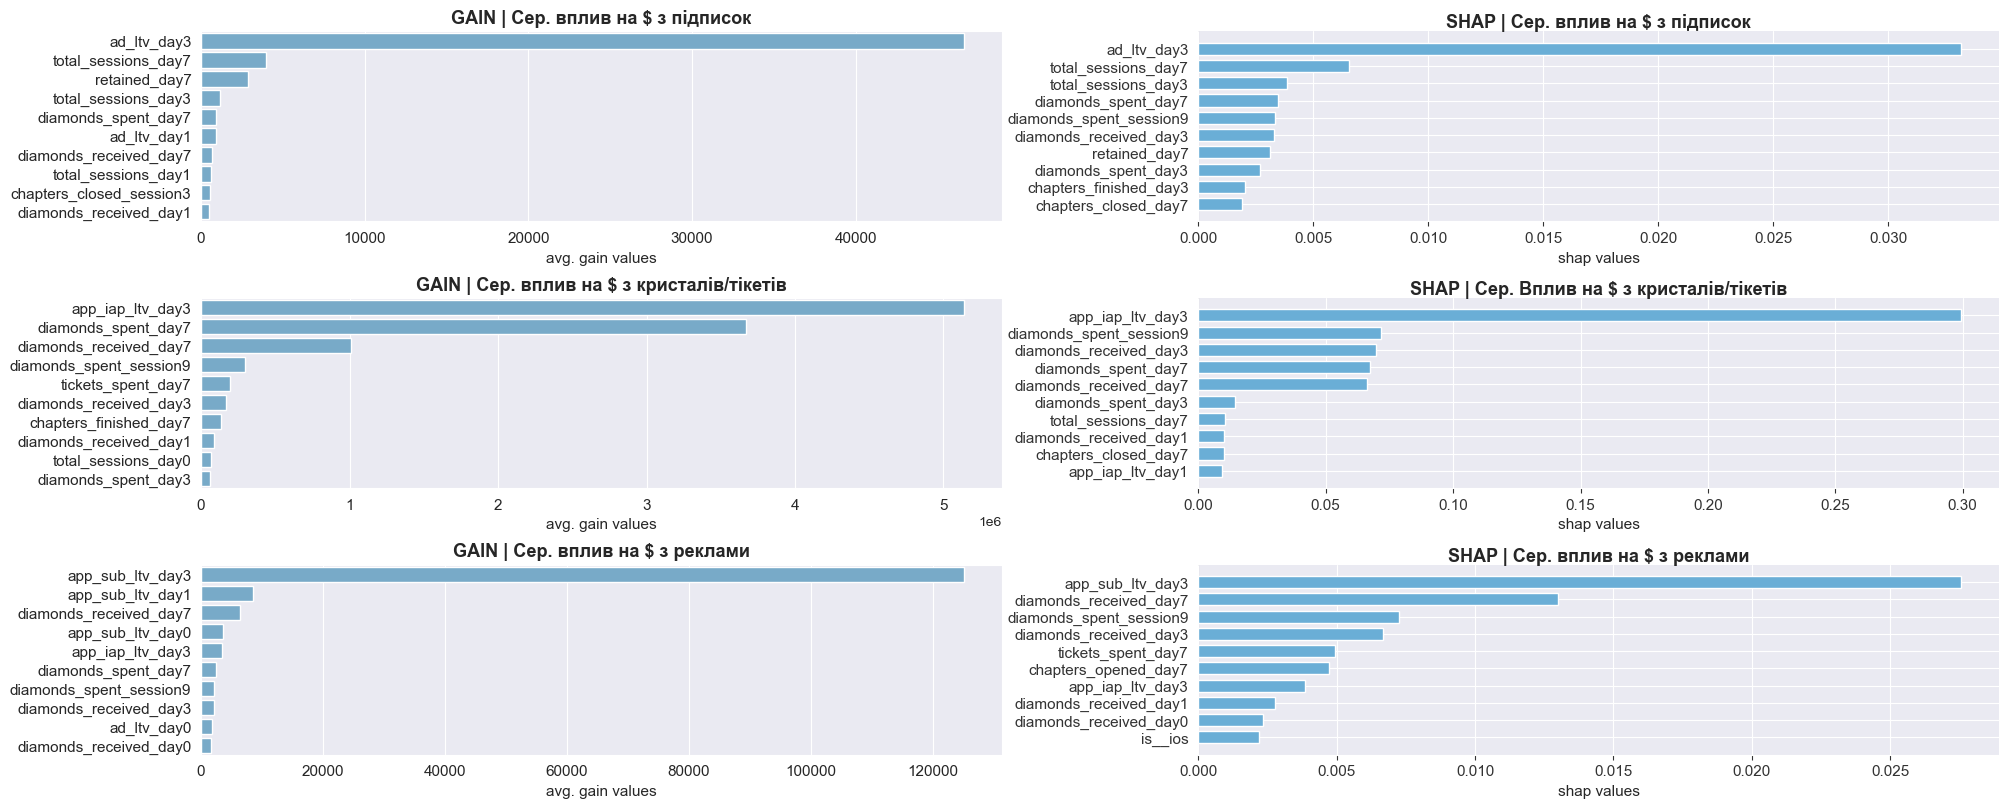

In [9]:
plot_feature_importance(X_test, xgb.model.estimators_)

Наступні два графіки покажуть як окремі значення впливають на кінцевий результат моделі, а саме негативно чи позитивно (-/+).

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


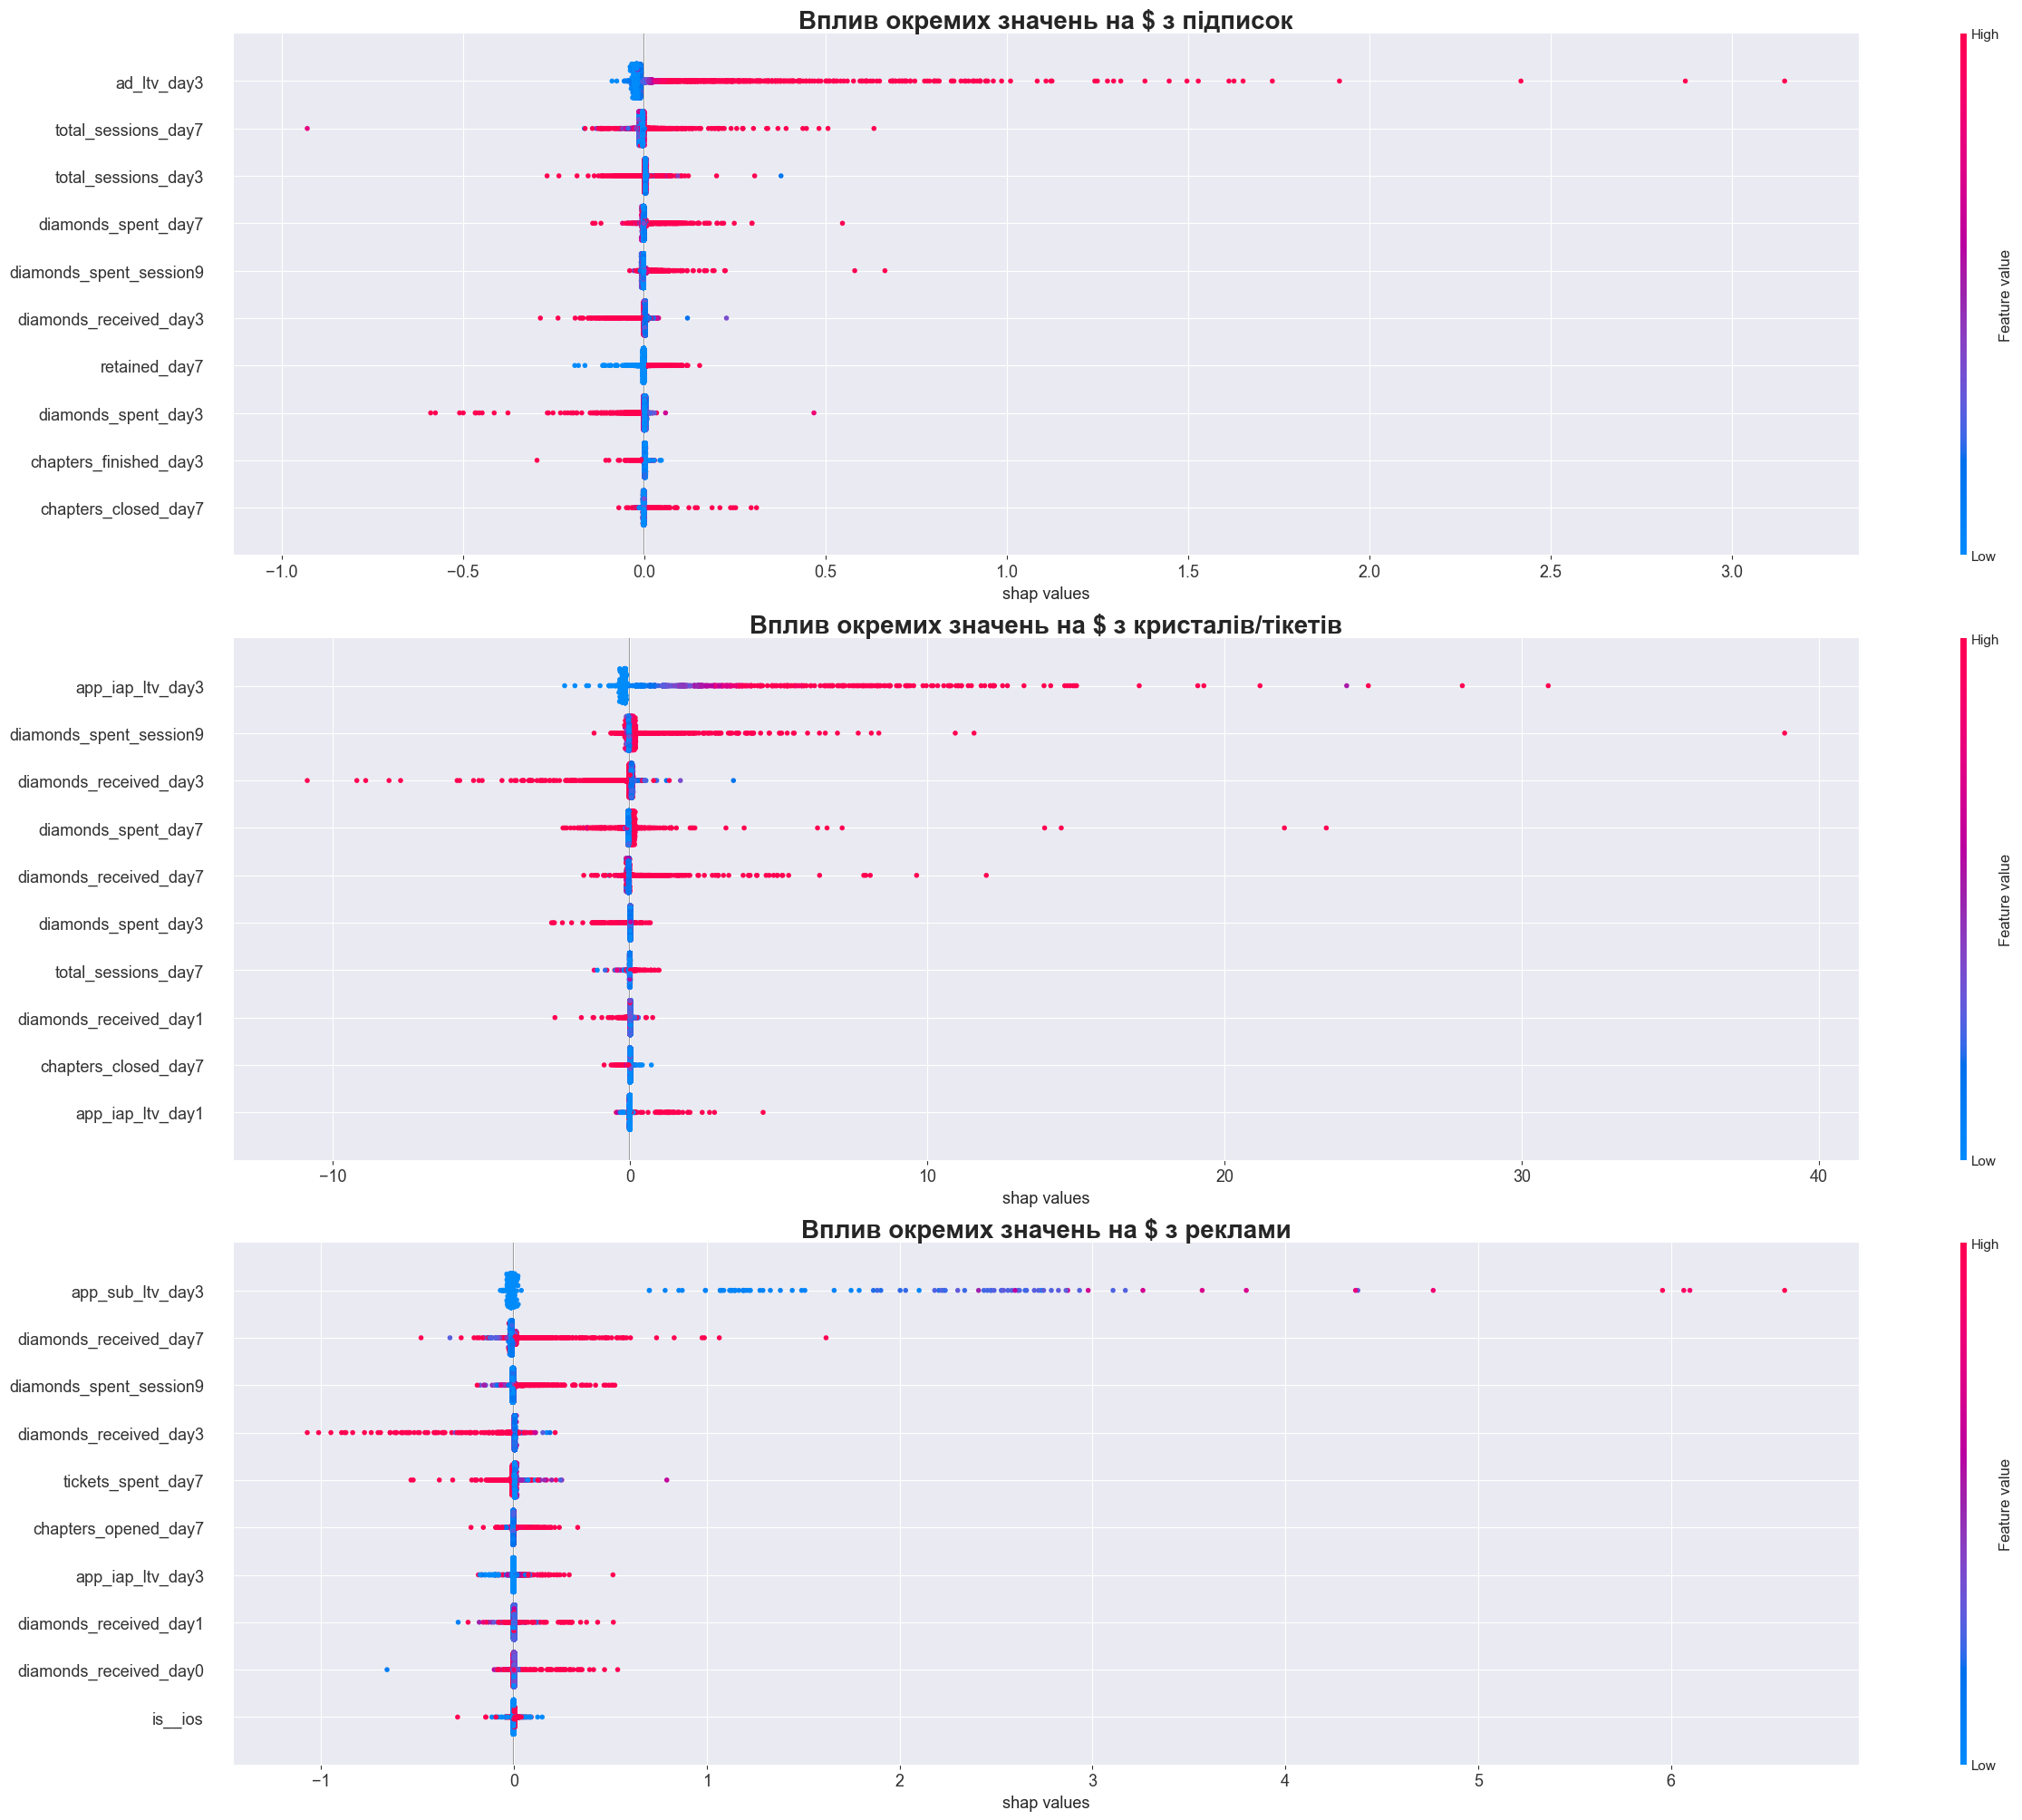

In [10]:
plot_feature_importance(X_test, xgb.model.estimators_, is_global=False)

Змінимо scale осі Х задля детального аналізу окремих значень.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


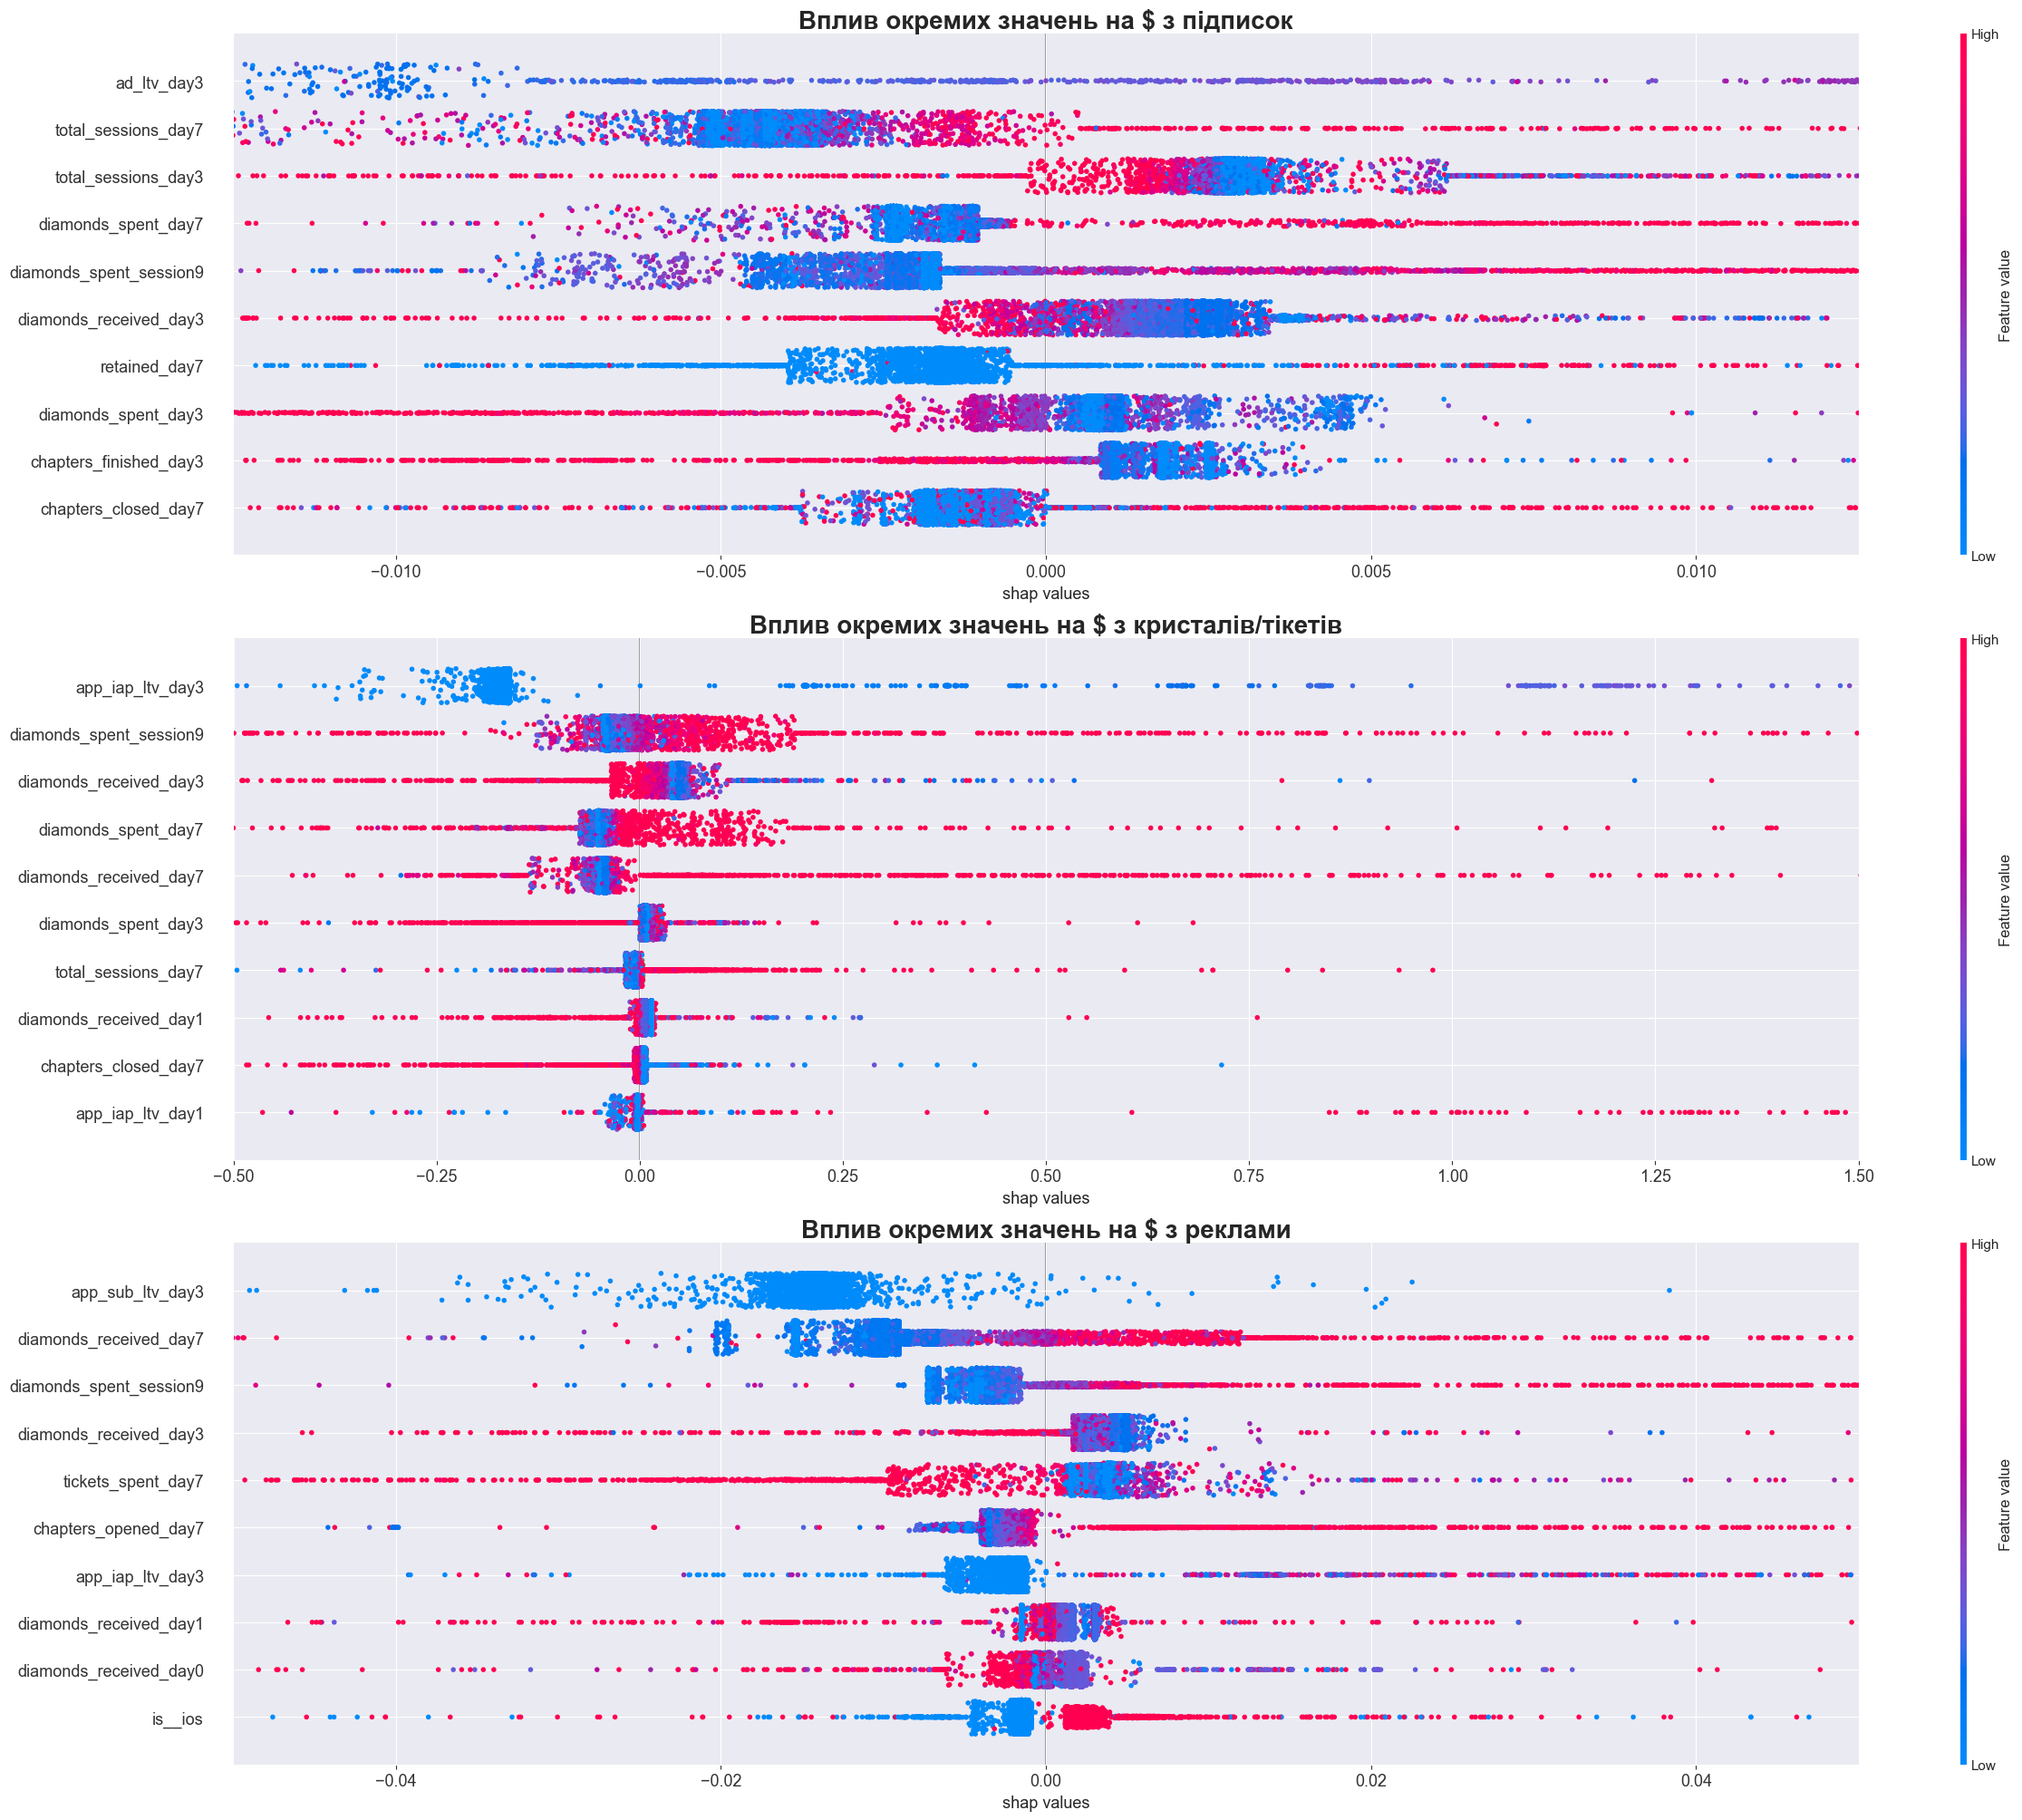

In [11]:
plot_feature_importance(X_test, xgb.model.estimators_, is_global=False, x_lims={'target_ad_ltv_day30': (-0.05, 0.05),
                                                                                'target_iap_ltv_day30': (-0.5, 1.5),
                                                                                'target_sub_ltv_day30': (-0.0125, 0.0125)
                                                                                })

Бачимо, що можливі випадки, коли незалежно від значень фічі, ці значення впливають в обидва боки (тобто зменш. та збільш. predictions). Тож треба дослідити, що може впливати на це. Вирогідно, існує кореляція з іншою фічею, яка створюю такі випадки.

In [12]:
titles = {
    'target_sub_ltv_day30': '$ з підписок',
    'target_iap_ltv_day30': '$ з кристалів/тікетів',
    'target_ad_ltv_day30': '$ з реклами'
}

def plot_dependencies(X, estimators_, features_dict={}):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))

    for index, target_key in enumerate(features_dict.keys()):
        index_of_target = TARGET.index(target_key)
        explainer = shap.TreeExplainer(estimators_[index_of_target])

        shap_values = explainer.shap_values(X)
        shap_features_list = features_dict[TARGET[index]]
        for feature_index, feature in enumerate(shap_features_list):
            shap.dependence_plot(feature, shap_values, X,
                                 ax=axes[index, feature_index], x_jitter=0.5, alpha=0.7, show=False)
            plt.tick_params('both', labelsize=13.0)

    plt.tight_layout(pad=0.5)

Розглянемо неоднозначні випадки на невідємній осі Y задля вирішення проблеми максимізації прибутку. Можемо спостерігати "цікаві" споріднення між двома фічами, які алгоритм знаходить корисними для розглядання. Аналіз може розширюватись навіть до спостереження кожної фіч з кожною іншою.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


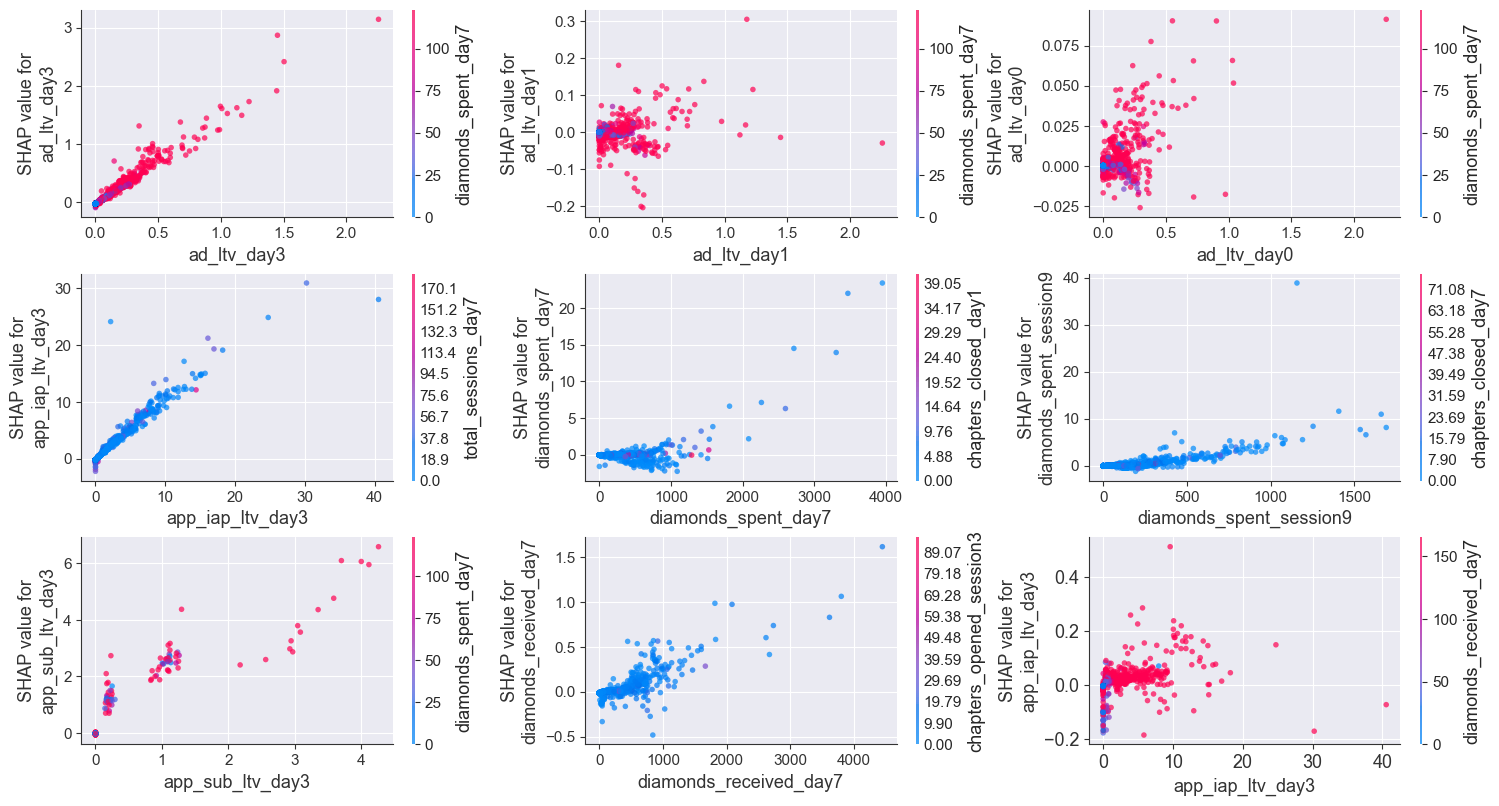

In [13]:
plot_dependencies(X_test, xgb.model.estimators_, features_dict={
    'target_sub_ltv_day30': ['ad_ltv_day3', 'ad_ltv_day1', 'ad_ltv_day0'],
    'target_iap_ltv_day30': ['app_iap_ltv_day3', 'diamonds_spent_day7', 'diamonds_spent_session9'],
    'target_ad_ltv_day30': ['app_sub_ltv_day3', 'diamonds_received_day7', 'app_iap_ltv_day3']
})

Отже враховуючи наведені вище дані можна зробити висновок, наприклад, для максимізації доходів з підписок, треба макс. дохід з реклами на 3-ий день, стимулювати к-сть сессій користувача на 7-ий день зростати, але мінімізувати к-сть отриманих кристалів на 3 день (напевно задля утримування інтересу до гри)

Щодо доходів з кристалів та тікетів, очевидно макс. доходи з купівлі кристалів/тікетів на 3 день, макс. витрачання користувачем кристалів на 9 день (певно це період після якого користувач схильний до покупки тих самих кристалів), але мін. к-сть отриманих кристалів на 3 день (адже це має великий негативний вплив на дохід). Стосовно доходів з реклами, мін. доходи з підписок (хоча існують випадки),  макс. к-сть отриманих кристалів на сьмоий день, та витрачення кристалів на 9 день.

Також утримуючи аудиторію у грі протягом тижня значно збільшує ймовірність того, що користувач стане дохідним. Варто звернути увагу на джерело трафіка користувачів, з якого гра отримує аудиторію найширше, та країни, в яких гра має популярність, можливо варто спробувати розширити аудиторію в непопулярних країнах скачування.

За допомогою визначеної моделі, в залежності від розподілу вибірки ми отримуємо точність близько 80 відсотків, що пов'язане з дуже нерівномірним розподілом гравців, що приносять грі прибуток, і великою кількістю "мертвих" акаунтів, що не дають змоги спрогнозувати чи гравець взагалі збирається повернутися до гри.